In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import StratifiedKFold
import time as tm
import itertools

In [30]:
def sq_hinge_func(X,Y,W):
    return (np.maximum(1-np.multiply(X.dot(W),Y),0))**2

In [9]:
# sq_hinge_func(X,Y,W)

In [7]:
X=np.array([[1,2,3,4],[3,4,5,6],[5,6,7,8],[7,8,9,9],[10,11,12,13]])
Y=np.array([1,-1,1,1,-1])
W=np.array([0.5,0.1,0.5,1])

# np.multiply(Y,Z)

In [28]:
def loss_func(X,Y,W,C=1):
#     print(W.shape,)
    loss = 0.5*W.dot(W)+ C*sum(sq_hinge_func(X,Y,W))
    return loss

In [24]:
def getStepLength( eta, t ):
    return eta/np.sqrt(t+1)

In [25]:
def sq_hinge_gradient(X,Y,W):
    pred = X.dot(W)
    n = Y.shape[0]
    gradients = np.zeros((n,))
    margin = np.multiply(Y,pred)
    gradients[margin < 1] = -2*(1-margin[margin<1])
    
    return gradients

In [26]:
def mini_batch_SGD(X,Y,n,_iter,W,C=1,eta=0.01):
    
    w = np.copy(W)
    sq_hinge_gr = sq_hinge_gradient(X,Y,w)  
    batch_size = X.shape[0]
    gradient = w + C * (n/batch_size)*(X.T*sq_hinge_gr).dot(Y)
    
    w = w- getStepLength(eta,_iter)*gradient
    return w

In [13]:
data = np.loadtxt('../data')

In [14]:
labels = data[:,0]
features = data[:,1:]

In [15]:
num_training = data.shape[0]

In [16]:
features = np.hstack((np.ones((num_training,1)),features))

In [20]:
def training(X,Y,W,C=1,eta=0.01,batch_size=128,n_iter=10):
    w = np.copy(W)
    loss = np.zeros(n_iter)
    n = X.shape[0]
    for i in range(n_iter):
        if (batch_size < n):
            tr_index = np.random.choice(range(0,n),batch_size)
            X_train,Y_train = X[tr_index,:],Y[tr_index]
        else:
            X_train,Y_train = X,Y
        w = mini_batch_SGD(X_train,Y_train,n,i,w,C,eta)
#         print()
        loss[i] = loss_func(X,Y,w,C)
    return w,loss
    
    

In [45]:
def predict(w,X):
    n = X.shape[0]
#     X = np.hstack((np.ones((n,1)),features))
    pred = np.ones(n)
    pred[X.dot(w) < 0] = -1 
    return pred

In [18]:
def KFold(n,split,shuffle=True):
    indices = [i for i in range(n)]
    random.shuffle(indices)
    split_index = [0,]
    for k in range(split-1):
        split_index.append(int(n*(k+1)/split))
    split_index.append(n)
#     print(split_index)
    folds=[]
    for tst in range(1,split+1):
        training_folds,test_folds=[],[]
        test_folds= indices[split_index[tst-1]:split_index[tst]]
        for tr in range(1,split+1):
            if(tr != tst):
                training_folds.extend(indices[split_index[tr-1]:split_index[tr]])
        folds.append([training_folds,test_folds])
        
    return folds

In [21]:
KFold(10,5)

[[[4, 6, 2, 5, 0, 1, 8, 3], [7, 9]],
 [[7, 9, 2, 5, 0, 1, 8, 3], [4, 6]],
 [[7, 9, 4, 6, 0, 1, 8, 3], [2, 5]],
 [[7, 9, 4, 6, 2, 5, 8, 3], [0, 1]],
 [[7, 9, 4, 6, 2, 5, 0, 1], [8, 3]]]

In [52]:
def cross_val(X,Y,C=1,eta=0.1,batch_size=128,n_iter=10):
    print("CV for C=",C,"eta=",eta,"batch_size=",batch_size)
    split = 3
    num_data = X.shape[0]
    cv = KFold(num_data,split,shuffle=True)
    loss=np.zeros(n_iter)
    i,mean = 0,0
    for tr_index, tst_index in cv:
        X_tr,Y_tr = X[tr_index],Y[tr_index]
        X_tst,Y_tst = X[tst_index],Y[tst_index]
        w = np.ones(X.shape[1])
        tic = tm.perf_counter()
        w,_loss = training(X_tr,Y_tr,w,C,eta,batch_size,n_iter)
        toc = tm.perf_counter()
#         print(loss.shape,_loss.shape)
#         loss += _loss
        loss += loss_func(X_tst,Y_tst,w)

        pred = predict(w,X_tst)
        mean += sum(pred == Y_tst)/(X_tst.shape[0])
        i+=1
        print('split: ',i,sum(pred == Y_tst)/(X_tst.shape[0]))
        
    plt.plot(range(n_iter),loss/split,label="C="+str(C)) 
    print(loss[-1]/split,toc-tic)
    print('Mean Accuracy: ',np.round(mean/split,3),"\n")
      

In [33]:
param

[(0.01, 32), (0.01, 128), (0.01, 512), (0.1, 32), (0.1, 128), (0.1, 512)]

CV for C= 1 eta= 0.0001 batch_size= 32
split:  1 0.8994899489948995
split:  2 0.9031048447577621
split:  3 0.9043047847607619
2420.863479564862 0.6997248239995315
Mean Accuracy:  0.902 

CV for C= 1 eta= 0.0001 batch_size= 128
split:  1 0.8966396639663966
split:  2 0.9062546872656367
split:  3 0.9056547172641368
2329.836625297548 0.5154197129995737
Mean Accuracy:  0.903 

CV for C= 1 eta= 0.0001 batch_size= 512
split:  1 0.9006900690069007
split:  2 0.9010049497525123
split:  3 0.9071546422678866
2309.2274717947325 0.6101998530002675
Mean Accuracy:  0.903 

CV for C= 1 eta= 0.0005 batch_size= 32
split:  1 0.9053405340534053
split:  2 0.8936553172341383
split:  3 0.9070046497675116
555427.6943000401 0.5153260059996683
Mean Accuracy:  0.902 

CV for C= 1 eta= 0.0005 batch_size= 128
split:  1 0.8897389738973898
split:  2 0.9034048297585121
split:  3 0.9113544322783861
10894.456329350616 0.5010020800000348
Mean Accuracy:  0.901 

CV for C= 1 eta= 0.0005 batch_size= 512
split:  1 0.91854185

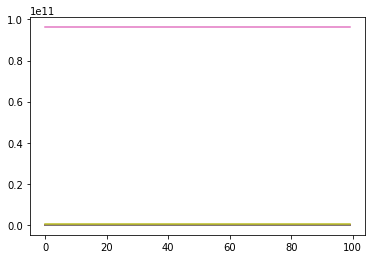

In [55]:
# C=[0.001,0.01,0.02]
eta = [0.0001,0.0005,0.001]
batch_size = [32,128,512]
param = list(itertools.product(eta,batch_size))
C = 1
# eta=0.0001
# batch_size =512
n_iter = 100
legends= []
for i in param:
    cross_val(features,labels,C,i[0],i[1],n_iter)
# w = np.ones(features.shape[1])
# w,loss = training(features,labels,w,C,eta,batch_size,n_iter)
# pred = predict(w,features)
# plt.plot(range(n_iter),loss,label="C="+str(C))  
# print('Mean Accuracy: ',np.round(sum(pred == labels)/(features.shape[0]),3),"\n")

In [164]:
loss[-1]

7251.691520843253

/home/umeshm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in double_scalars
/home/umeshm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in multiply
/home/umeshm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
/home/umeshm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in subtract
/home/umeshm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


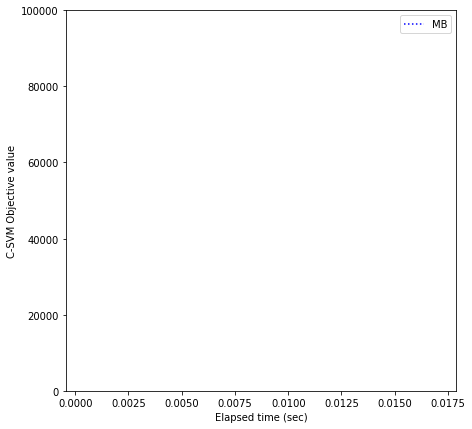

In [141]:
import time as tm

X = features
y = labels
d = X.shape[1]
def getCSVMGrad( theta ):
    w = theta[0:-1]
    b = theta[-1]
    discriminant = np.multiply( (X.dot( w ) + b), y )
    g = np.zeros( (y.size,) )
    g[discriminant < 1] = -2*(1-discriminant[discriminant<1])
    delb = C * g.dot( y )
    delw = w + C * (X.T * g).dot( y )
    return np.append( delw, delb )

# Get a stochastic gradient for the CSVM objective
# Choose a random data point per iteration
def getCSVMSGrad( theta ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    i = random.randint( 0, n-1 )
    x = X[i,:]
    discriminant = (x.dot( w ) + b) * y[i]
    g = 0
    if discriminant < 1:
        g = -1
    delb = C * n * g * y[i]
    delw = w + C * n * (x * g) * y[i]
    return np.append( delw, delb )

# Get a mini-batch stochastic gradient for CSVM
# Choose a random set of B samples per iteration
def getCSVMMBGrad( theta ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    if B <= n:
        samples = random.sample( range(0, n), B )
        X_ = X[samples,:]
        y_ = y[samples]
    else:
        X_ = X
        y_ = y
    discriminant = np.multiply( (X_.dot( w ) + b), y_ )
    g = np.zeros( (B,) )
    g[discriminant < 1] = -2*(1-discriminant[discriminant<1])
    delb = C * n/B * g.dot( y_ )
    delw = w + C * n/B * (X_.T * g).dot( y_ )
    return np.append( delw, delb )

# Quite standard for strongly convex but non-smooth objectives like CSVM
def getStepLength( grad, t ):
    return eta/(t+1)

# Get the CSVM objective value in order to plot convergence curves
def getCSVMObjVal( theta ):
    w = theta[0:-1]
    b = theta[-1]
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w ) + b), y ), 0 )
    return 0.5 * w.dot( w ) + C * hingeLoss.dot(hingeLoss)

# Given a gradient oracle, a step length oracle, an initialization,
# perform GD for a specified number of steps (horizon)
# An "oracle" is a fancy name for a function that does a certain job perfectly
def doGD( gradFunc, stepFunc, init, horizon = 10 ):
    objValSeries = np.zeros( (horizon,) )
    timeSeries = np.zeros( (horizon,) )
    totTime = 0
    theta = init
    cumulative = init
    for t in range( horizon ):
        tic = tm.perf_counter()
        delta = gradFunc( theta )
        theta = theta - stepFunc( delta, t+1 ) * delta
        cumulative = cumulative + theta
        toc = tm.perf_counter()
        totTime = totTime + (toc - tic)
        objValSeries[t] = getCSVMObjVal( cumulative/(t+2) )
        timeSeries[t] = totTime
    return (cumulative/(horizon+1), objValSeries, timeSeries)

def mySVM( X ):
    return X.dot(w) + b

# CSVM problems get progressively more and more difficult as C goes up
# All solvers, GD/SGD/sklearn will struggle with large values of C
# C = 1
# eta = 1000
# (theta, obj, time) = doGD( getCSVMGrad, getStepLength, np.zeros( (d+1,) ), horizon = 1000 )

# Experiment to observe that SGD and MB offer much faster convergence than GD, especially when n is large
# Also, plot just the SGD and MB curves repeatedly to observe that the SGD curve jitters from execution
# to execution (an indication of variance) whereas the MB curve remains relatively stable across executions
C = 1
eta = 1
B = 128
# (theta_SGD, obj_SGD, time_SGD) = doGD( getCSVMSGrad, getStepLength, np.zeros( (d+1,) ), horizon = 10000 )
(theta_MB, obj_MB, time_MB) = doGD( getCSVMMBGrad, getStepLength, np.zeros( (d+1,) ), horizon = 1000 )

# w = theta[0:-1]
# b = theta[-1]

# fig = pd.getFigure( 7, 7 )
# plt.figure( figsize=(7,7) )

# pd.shade2D( mySVM, fig, mode = 'batch', xlim = 10, ylim = 10 )
# pd.plot2D( XPos, fig, color = 'r', marker = '+' )
# pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )
# plt.show()

# w = theta_SGD[0:-1]
# b = theta_SGD[-1]

# fig2 = pd.getFigure( 7, 7 )
# plt.figure( figsize=(7,7) )

# # pd.shade2D( mySVM, fig, mode = 'batch', xlim = 10, ylim = 10 )
# # pd.plot2D( XPos, fig, color = 'r', marker = '+' )
# # pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )
# plt.show()

w = theta_MB[0:-1]
b = theta_MB[-1]

# plt.figure( figsize=(7,7) )

# pd.shade2D( mySVM, fig, mode = 'batch', xlim = 10, ylim = 10 )
# pd.plot2D( XPos, fig, color = 'r', marker = '+' )
# pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )
# plt.show()
obj_MB[-1]
plt.figure( figsize=(7,7) )
# plt.plot( time, obj, color = 'k', linestyle = '--', label = "GD" )
# plt.plot( time_SGD, obj_SGD, color = 'r', linestyle = '-', label = "SGD" )
plt.plot( time_MB, obj_MB, color = 'b', linestyle = ':', label = "MB" )
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
plt.legend()
plt.ylim( 0, 100000 )
plt.show()

In [133]:
obj_MB[-1]

5511.637738926602